In [1]:
#Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
#Leer Dataframes
books = pd.read_excel('books_data.xlsx')
ratings = pd.read_excel('Books_rating.xlsx')

In [3]:
print(len(books))   #número de filas del dataframe books
print(len(ratings)) #número de filas del dataframe ratings

212404
1048575


In [4]:
books = books[['Title','description','categories']]
ratings = ratings[['Title','User_id','review/score']]
books = books.dropna().reset_index()
ratings = ratings.dropna().reset_index()

In [5]:
books=books.sample(n=30000, random_state=42).reset_index() #solo tomamos 100000 filas del dataframe books porque el codigo no carga mas adelante con mas datos

In [6]:
ratings=ratings[ratings['Title'].isin(books['Title'])] # filtramos el dataframe con los ratings solo a los libros de los que tenemos calificaciones

In [7]:
ratings=ratings.sample(n=30000, random_state=42).reset_index()

In [8]:
print(len(books))   #número de filas del dataframe books para corroborar la cantidad de filas
print(len(ratings)) #número de filas del dataframe ratings para corroborar la cantidad de filas

30000
30000


In [9]:
#Analizamos los dataframes
print(books.columns)
print(books.shape)
print(ratings.columns)
print(ratings.shape)
print(books.info())
print(ratings.info())

Index(['level_0', 'index', 'Title', 'description', 'categories'], dtype='object')
(30000, 5)
Index(['level_0', 'index', 'Title', 'User_id', 'review/score'], dtype='object')
(30000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   level_0      30000 non-null  int64 
 1   index        30000 non-null  int64 
 2   Title        30000 non-null  object
 3   description  30000 non-null  object
 4   categories   30000 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   level_0       30000 non-null  int64 
 1   index         30000 non-null  int64 
 2   Title         30000 non-null  object
 3   User_id       30000 non-null  object
 4   r

In [10]:
print(books.head())
print(ratings.head())

   level_0   index                                              Title  \
0    25417   35577                                    Rampaging Bulls   
1    92790  140829            The Principles of Statistical Mechanics   
2    35349   50009  Financial Engineering and Computation: Princip...   
3    25845   36168  Adobe Scripting: Your Visual Blueprint to Scri...   
4   123605  187497  Diagnosing and Treating Codependence: A Guide ...   

                                         description        categories  
0  Rampaging Bulls, written by an investor and wr...  ['Penny stocks']  
1  This is the definitive treatise on the fundame...       ['Science']  
2  Students and professionals intending to work i...   ['Mathematics']  
3  * Written by New York graphic design professio...     ['Computers']  
4  In Practicing Prodependence: The Clinical Alte...    ['Psychology']  
   level_0   index                                              Title  \
0   695974  860439   A Drummer's Beat to Mend (Lov

In [11]:
#Esta funcion lo que hace es que al agregar un usuario real devuelve una lista de libros que este clificó por lo tanto son libros comprados reales
def lista_real(usuario):
    lista=ratings.loc[ratings['User_id']== usuario]
    lista=lista['Title']
    lista=lista.to_list()
    return lista

### Primero realizamos un sistema de recomendación basado en contenido para esto utilizaremos el dataframe "Books" ya que necesitamos las características de los libros, el cual en este dataframe esta informacion se encuentra en la descripción, para calcular la similitud entre ellos y recomendar elementos similares

Las columnas de nuestro interés para hacer las recomendaciones son 'description' y 'categories' asi que las combinaremos

In [12]:
#Los datos de la columna categories tienen el siguiente formato: '['Comics & Graphic Novels']' por lo que eliminaremos los simbolos [' y ']
#Por otro lado de la columna 'description' quitaremos los puntos y comas todo esto con el fin de que el código pueda relacionar el conteido correctamente y no descarte similitudes por un punto entre palabras 

books['categories'] = books['categories'].str.replace("\']", '').str.replace("\['", '')
books['description'] = books['description'].str.replace("\.", '').str.replace("\,", '')
#Observamos como quedan las columna pidiendole UN valor de cada una como ejemplo
print(books['categories'].sample(1))
print(books['description'].sample(1))

12241    ['Architecture
Name: categories, dtype: object
26009    Surprise your friends! Astonish your family! W...
Name: description, dtype: object


In [13]:
# Combinamos columnas 'description' y 'categories' para nuestras recomendaciones
books['combined'] = books['description'] + ' ' + books['categories']
print(books['combined'].sample(1))

26600    This powerful account of the oppression of wom...
Name: combined, dtype: object


In [14]:
#Ahora vamos a vamos a representar los items en un formato que la máquina pueda entender, Con la vectorización. Para convertir texto en una representación numérica 
count = TfidfVectorizer()
count_matrix = count.fit_transform(books['combined'])

In [15]:
# Calcular la similitud entre las descripciones de los libros
# Usaremos la similitud del coseno
similarity = cosine_similarity(count_matrix,count_matrix)

In [16]:
#Ahora crearemos una fucnión que a agregar el título de un libro devuelva los libros mas similares a el 
def recommendations(Title, similarity):
    recommended_books = []

    # Verificar si el título está presente en el DataFrame
    if Title in books['Title'].values:
        # Obtenemos el índice del libro que coincide con el elegido
        indice = books[books['Title'] == Title].index[0]

        # Obtenemos los scores de similitud de coseno para ese libro con todos los libros
        score_series = pd.Series(similarity[indice]).sort_values(ascending=False)

        # Obtenemos los 10 indices de libros con mayor similitud
        top_10 = list(score_series.iloc[1:11].index)

        for i in top_10:
            recommended_books.append(books['Title'][i])
    else:
        print("El título del libro no se encuentra en los datos.")

    return recommended_books

In [17]:
book_title = 'Banishment'
recommended__books = recommendations(book_title, similarity=similarity)

print(f"Libros recomendados para '{book_title}':")
for book in recommended__books:
    print(book)

Libros recomendados para 'Banishment':
Rebels with a Cause: The Minds and Morality of Political Offenders
Historic Towns of the Western States
Historic towns of the western states
Pueblo, Hardscrabble, Greenhorn: Society on the High Plains, 1832-1856
Kinkeeper (New Women's Voices Series, No. 18)
The Maritime History of the World **Volumes 1 & 2**
Colonial Odysseys: Empire and Epic in the Modernist Novel
The History of Government from the Earliest Times: Ancient Monarchies and Empires; The Intermediate Ages; Empires, Monarchies and the Modern State (3 Volume Set)
The Italian Boy: A Tale of Murder and Body Snatching in 1830s London
Gentle Invaders: Quaker Women Educators and Racial Issues During the Civil War and Reconstruction


### Ahora realizamos un sistema de recomendación de filtro colaborativo para esto utilizaremos el dataframe "Ratings" ya que necesitamos información sobre las interacciones entre usuarios y libros, como las calificaciones o las compras realizadas.

Las columnas de nuestro interés para hacer las recomendaciones son 'description' y 'categories' asi que las combinaremos

In [18]:
# Creamos una matriz de puntaje, para eso utilizamos los Id de usuario como index y el Titulo de libro como columnas y el contenido las reviews
ratings_matrix = ratings.pivot_table(index='User_id',columns='Title', values='review/score',aggfunc='mean').fillna(0)

In [19]:
# Calculamos la similitud entre usuarios basada en las calificaciones utilizando la similitud del coseno
User_similarity = cosine_similarity(ratings_matrix.fillna(0))

In [20]:
def collaborative_filtering(User_id, ratings_matrix, User_similarity, top_n=10):
    # Obtener el índice numérico correspondiente al ID del usuario
    User_index = ratings_matrix.index.get_loc(User_id)
    
    # Obtener las similitudes del usuario dado con todos los usuarios
    User_similarities = User_similarity[User_index]
    
    # Obtener los índices de los usuarios más similares al usuario dado (excluyendo al usuario dado)
    similar_user_indices = np.argsort(User_similarities)[::-1][1:top_n+1]
    
    # Obtener las calificaciones del usuario dado
    User_ratings = ratings_matrix.iloc[User_index].fillna(0)
    
    # Obtener las calificaciones promedio de los usuarios similares
    similar_users_ratings = ratings_matrix.iloc[similar_user_indices].mean()
    
    # Obtener los libros que los usuarios similares han calificado positivamente y que el usuario dado no ha calificado
    recommended_books = similar_users_ratings[User_ratings == 0].sort_values(ascending=False)[:top_n]
    
    return recommended_books.index

In [21]:
User_id = 'A1CNQTCRQ35IMM'
recommended_books = collaborative_filtering(User_id, ratings_matrix, User_similarity=User_similarity)
print(f"Recomendaciones para el usuario {User_id}:")
for Title in recommended_books:
    print(Title)

Recomendaciones para el usuario A1CNQTCRQ35IMM:
"THE GOBLET AND THE RESTLESS GHOST"
Starburst
Statistical Inference: An Integrated Approach (Chapman & Hall/CRC Texts in Statistical Science Series)
Statistical Analysis in Climate Research
Statistical Analyses for Language Assessment Workbook and CD ROM (Cambridge Language Assessment)
Stash Envy
Start Your Own Specialty Travel & Tour Business (Start Your Own Specialty Travel & Tour Business)
Start Making Sense: Turning the Lessons of Election 2004 into Winning Progressive Politics
Stars (Gem)
Starlight


## Evaluar los sistemas


In [22]:
#Definimos la funcion para calcular la precisión k para el modelo basado en contenido
def precision_k(recommended_books, test_ratings, k):
    # Tomar los primeros k elementos de los libros recomendados
    recommended_k = recommended_books[:k]
    
    # Calcular la intersección entre los libros recomendados y los libros reales
    intersection = set(recommended_k) & set(test_ratings)
    
    # Calcular la precisión en k
    precision = len(intersection) / k
    
    return precision

#Definimos la funcion para calcular la precisión k para el modelo de filtro colaborativo

def precision_at_k(User_id, recommended_books, test_ratings, k):
    # Filtrar las calificaciones de prueba para el usuario dado
    test_user_ratings = test_ratings[test_ratings['User_id'] == User_id]
    
    # Obtener los libros verdaderamente relevantes (calificados positivamente) por el usuario en los datos de prueba
    relevant_books = test_user_ratings[test_user_ratings['Title'].isin(recommended_books)]
    
    # Calcular la precisión en k
    precision = len(relevant_books) / k
    
    return precision


In [23]:
books['Title'] = books['Title'].str.replace("\'", '') #Elimina caracteres que pueden molestar en el código 


In [24]:
print(ratings['User_id'].sample(1)) #para sacar un ejemplo de usuario real

29970    A2W07L4J31G8WR
Name: User_id, dtype: object


In [25]:

User_id = 'A1CNQTCRQ35IMM'
test_ratings = lista_real(User_id)
print(test_ratings)


['Saving Grace', 'Little Women', 'Carrie', 'The Girl Who Loved Tom Gordon', 'Dead Cert', 'Running Blind', 'Visitor', 'Hot Shot']


In [26]:
book_title = test_ratings[0] #toma el primer libro de la lista para sacar las recomendaciones
print(book_title)

Saving Grace


In [27]:
#libros recomendados para el modelo basado en contenido
recommended_books_content_based = recommendations(book_title, similarity=similarity)
print(f"Libros recomendados para '{book_title}':")
for book in recommended_books_content_based:
    print(book)

Libros recomendados para 'Saving Grace':
Society: The Basics (6th Edition)
The Book of Understanding: Creating Your Own Path to Freedom
Grace and Truth
Unnatural Affection
The Beauty of the Beast: Breathing New Life Into Organizations
Beyond the Twelve Steps: Roadmap to a New Life
Alias Grace: Complete & Unabridged
Love for an Enemy
Interview With An American Monk
Human/Nature


In [28]:
#libros recomendados para el modelo basado en filtro colaborativo
recommended_books_collaborative_filtering = collaborative_filtering(User_id, ratings_matrix, User_similarity=User_similarity)
print(f"Recomendaciones para el usuario {User_id}:")
for Title in recommended_books_collaborative_filtering:
    print(Title)

Recomendaciones para el usuario A1CNQTCRQ35IMM:
"THE GOBLET AND THE RESTLESS GHOST"
Starburst
Statistical Inference: An Integrated Approach (Chapman & Hall/CRC Texts in Statistical Science Series)
Statistical Analysis in Climate Research
Statistical Analyses for Language Assessment Workbook and CD ROM (Cambridge Language Assessment)
Stash Envy
Start Your Own Specialty Travel & Tour Business (Start Your Own Specialty Travel & Tour Business)
Start Making Sense: Turning the Lessons of Election 2004 into Winning Progressive Politics
Stars (Gem)
Starlight


In [29]:
#calculamos la presicion K para el modelo basado en contenido
precision_content_based = precision_k(recommended_books_content_based, test_ratings,10)
print(precision_content_based)

0.0


In [30]:
#calculamos la presicion K para el modelo basado en filtro colaborativo
k=10
precision_collaborative_filtering = precision_at_k(User_id, recommended_books_collaborative_filtering, ratings, k)
print(precision_collaborative_filtering)

0.0


# Graficamos las categorias de los libros recomendados de cada función

In [32]:
User_id = 'A1CNQTCRQ35IMM'
test_ratings = lista_real(User_id)
print(test_ratings)
book_title = test_ratings[0] #toma el primer libro de la lista para sacar las recomendaciones
print('')
print('El libro que usaremos para sacar recomendaciones es:')
print(book_title)

['Saving Grace', 'Little Women', 'Carrie', 'The Girl Who Loved Tom Gordon', 'Dead Cert', 'Running Blind', 'Visitor', 'Hot Shot']

El libro que usaremos para sacar recomendaciones es:
Saving Grace


In [33]:
#libros recomendados para el modelo basado en contenido
recommended_books_content_based = recommendations(book_title, similarity=similarity)
print(f"Libros recomendados para '{book_title}':")
for book in recommended_books_content_based:
    print(book)

Libros recomendados para 'Saving Grace':
Society: The Basics (6th Edition)
The Book of Understanding: Creating Your Own Path to Freedom
Grace and Truth
Unnatural Affection
The Beauty of the Beast: Breathing New Life Into Organizations
Beyond the Twelve Steps: Roadmap to a New Life
Alias Grace: Complete & Unabridged
Love for an Enemy
Interview With An American Monk
Human/Nature


In [40]:
recommended_categories_content_based = books.loc[books['Title'].isin(recommended_books_content_based), 'categories']
category_counts_content_based = recommended_categories_content_based.value_counts()


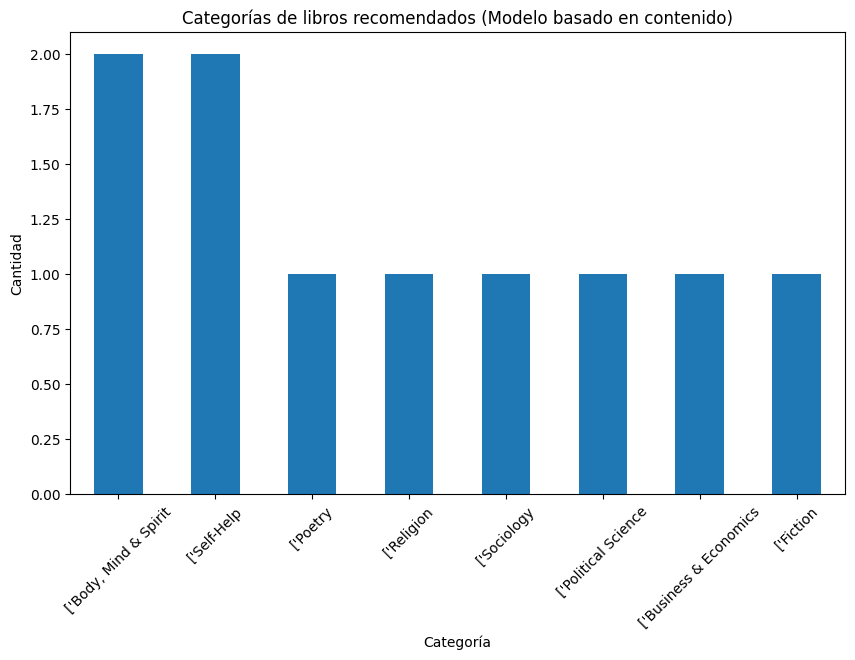

In [41]:
plt.figure(figsize=(10, 6))
category_counts_content_based.plot(kind='bar')
plt.title('Categorías de libros recomendados (Modelo basado en contenido)')
plt.xlabel('Categoría')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()


In [35]:
#libros recomendados para el modelo basado en filtro colaborativo
recommended_books_collaborative_filtering = collaborative_filtering(User_id, ratings_matrix, User_similarity=User_similarity)
print(f"Recomendaciones para el usuario {User_id}:")
for Title in recommended_books_collaborative_filtering:
    print(Title)

Recomendaciones para el usuario A1CNQTCRQ35IMM:
"THE GOBLET AND THE RESTLESS GHOST"
Starburst
Statistical Inference: An Integrated Approach (Chapman & Hall/CRC Texts in Statistical Science Series)
Statistical Analysis in Climate Research
Statistical Analyses for Language Assessment Workbook and CD ROM (Cambridge Language Assessment)
Stash Envy
Start Your Own Specialty Travel & Tour Business (Start Your Own Specialty Travel & Tour Business)
Start Making Sense: Turning the Lessons of Election 2004 into Winning Progressive Politics
Stars (Gem)
Starlight


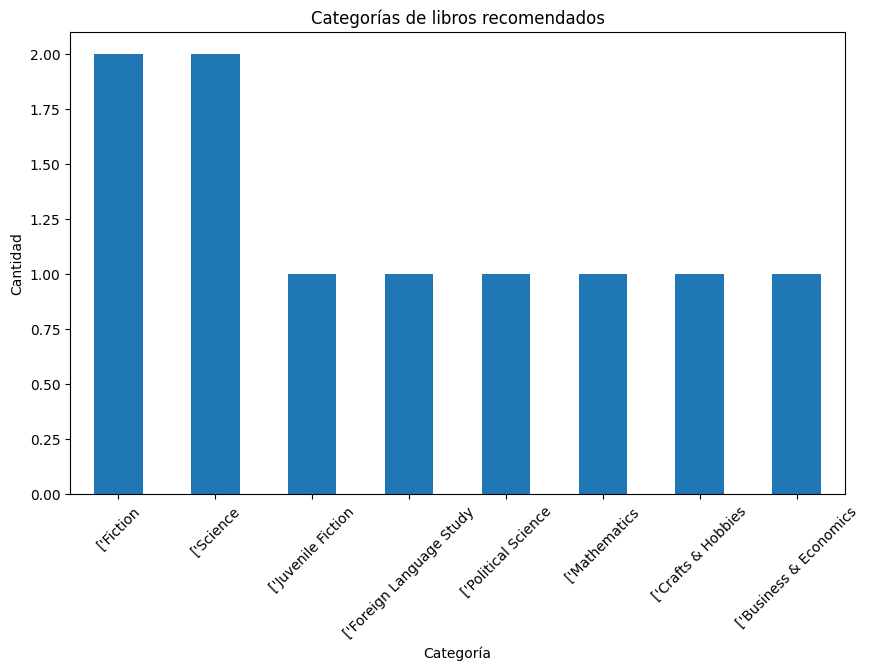

In [36]:
# Obtener las categorías de los libros recomendados
recommended_categories = books.loc[books['Title'].isin(recommended_books_collaborative_filtering), 'categories']

# Contar la cantidad de libros recomendados por categoría
category_counts = recommended_categories.value_counts()

# Graficar las categorías
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Categorías de libros recomendados')
plt.xlabel('Categoría')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

# Comparacion de categorias
### los graficos comparan la similitud de categorias que recomienda cada modelo

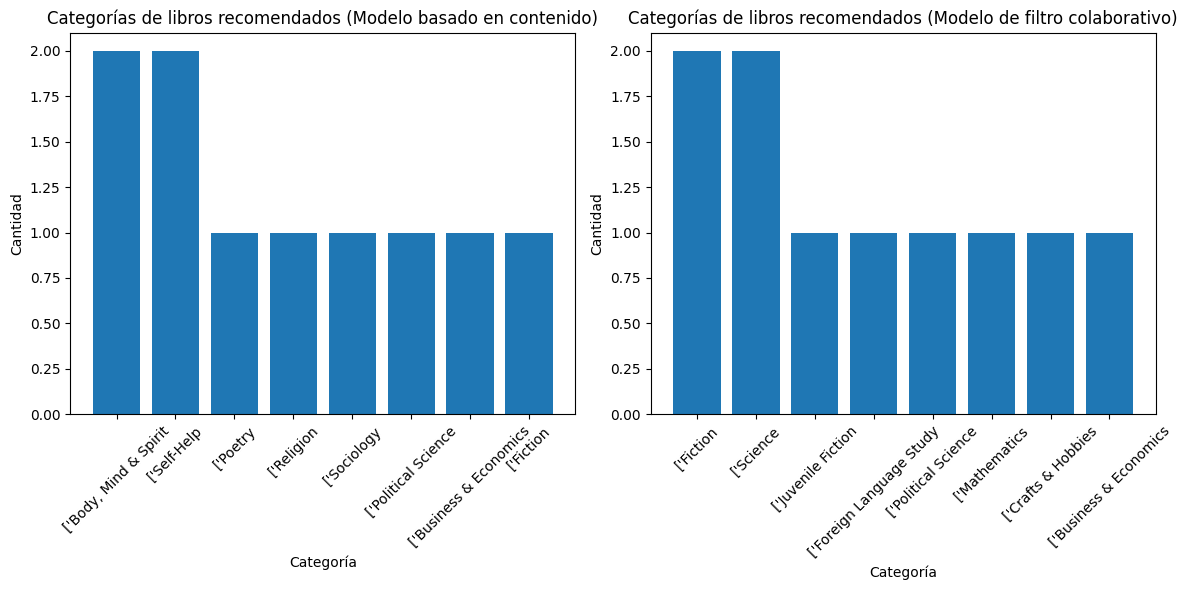

In [48]:
# Gráfico para el modelo basado en contenido
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico para el modelo basado en contenido
axes[0].bar(category_counts_content_based.index, category_counts_content_based.values)
axes[0].set_title('Categorías de libros recomendados (Modelo basado en contenido)')
axes[0].set_xlabel('Categoría')
axes[0].set_ylabel('Cantidad')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico para el modelo de filtro colaborativo
axes[1].bar(category_counts.index, category_counts.values)
axes[1].set_title('Categorías de libros recomendados (Modelo de filtro colaborativo)')
axes[1].set_xlabel('Categoría')
axes[1].set_ylabel('Cantidad')
axes[1].tick_params(axis='x', rotation=45)

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar los gráficos
plt.show()


In [42]:
categories_content_based = set(recommended_categories_content_based.unique())
categories_collaborative_filtering = set(recommended_categories.unique())


In [43]:
common_categories = categories_content_based & categories_collaborative_filtering


In [44]:
exclusive_categories_content_based = categories_content_based - categories_collaborative_filtering
exclusive_categories_collaborative_filtering = categories_collaborative_filtering - categories_content_based


In [45]:
num_categories_content_based = len(categories_content_based)
num_categories_collaborative_filtering = len(categories_collaborative_filtering)


In [46]:
print("Categorías comunes en ambos modelos:")
print(common_categories)

print("Categorías exclusivas del modelo basado en contenido:")
print(exclusive_categories_content_based)

print("Categorías exclusivas del modelo de filtro colaborativo:")
print(exclusive_categories_collaborative_filtering)

print("Cantidad de categorías en el modelo basado en contenido:", num_categories_content_based)
print("Cantidad de categorías en el modelo de filtro colaborativo:", num_categories_collaborative_filtering)


Categorías comunes en ambos modelos:
{"['Fiction", "['Business & Economics", "['Political Science"}
Categorías exclusivas del modelo basado en contenido:
{"['Self-Help", "['Body, Mind & Spirit", "['Sociology", "['Religion", "['Poetry"}
Categorías exclusivas del modelo de filtro colaborativo:
{"['Mathematics", "['Foreign Language Study", "['Juvenile Fiction", "['Crafts & Hobbies", "['Science"}
Cantidad de categorías en el modelo basado en contenido: 8
Cantidad de categorías en el modelo de filtro colaborativo: 8


# Compararcion de precisiones entre modelos

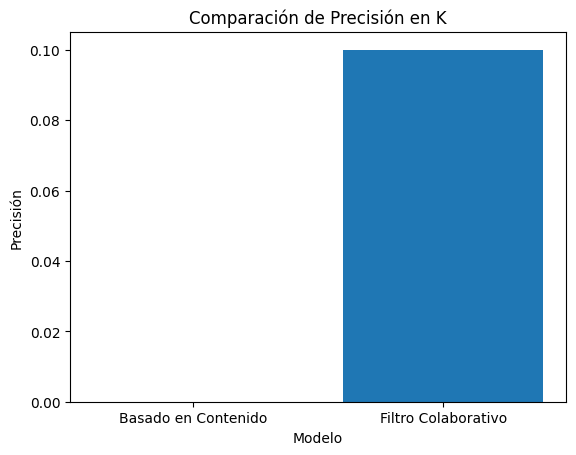

In [59]:
# Precisión en K para el modelo basado en contenido y colaborativo
precision_content_based = precision_k(recommended_books_content_based, test_ratings, k)
precision_collaborative_filtering = precision_at_k(User_id, recommended_books_collaborative_filtering, ratings, k)

# Crear una lista con los valores de precisión
precisions = [precision_content_based, precision_collaborative_filtering]

# Crear una lista con los nombres de los modelos
model_names = ['Basado en Contenido', 'Filtro Colaborativo']

# Crear un gráfico de barras
plt.bar(model_names, precisions)

# Agregar título y etiquetas a los ejes
plt.title('Comparación de Precisión en K')
plt.xlabel('Modelo')
plt.ylabel('Precisión')

# Mostrar el gráfico
plt.show()


# comparacion de recomendaciones
### el grafico muestra las recomendaciones coincidentes entre modelos

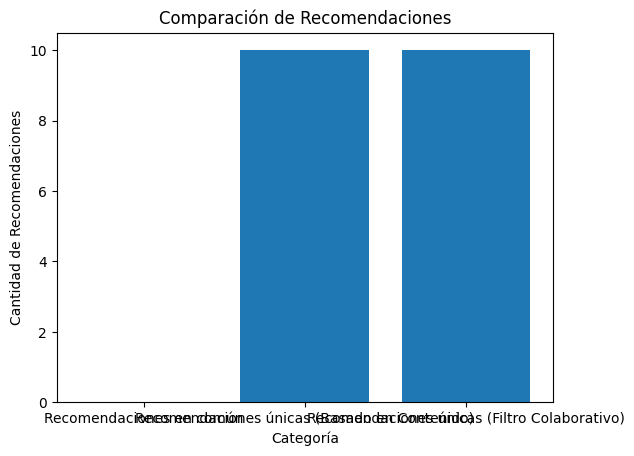

In [58]:
# Obtener la cantidad de recomendaciones coincidentes
recomendaciones_comunes = len(set(recommended_books_content_based) & set(recommended_books_collaborative_filtering))

# Obtener la cantidad de recomendaciones únicas para cada modelo
recomendaciones_unicas_content_based = len(set(recommended_books_content_based) - set(recommended_books_collaborative_filtering))
recomendaciones_unicas_collaborative_filtering = len(set(recommended_books_collaborative_filtering) - set(recommended_books_content_based))

# Crear una lista con las cantidades de recomendaciones
cantidades_recomendaciones = [recomendaciones_comunes, recomendaciones_unicas_content_based, recomendaciones_unicas_collaborative_filtering]

# Crear una lista con los nombres de las categorías
categorias = ['Recomendaciones en común', 'Recomendaciones únicas (Basado en Contenido)', 'Recomendaciones únicas (Filtro Colaborativo)']

# Crear un gráfico de barras
plt.bar(categorias, cantidades_recomendaciones)

# Agregar título y etiquetas a los ejes
plt.title('Comparación de Recomendaciones')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Recomendaciones')

# Mostrar el gráfico
plt.show()


# Comparacion en la Diversidad de las recomendaciones 
### calcula la cantidad de categorías únicas entre las recomendaciones de cada modelo y graficar esta información

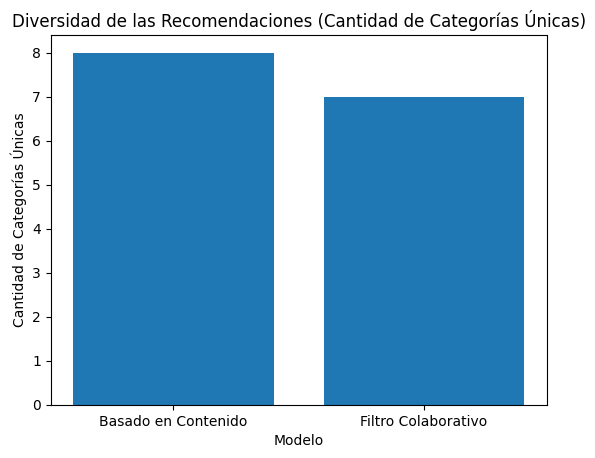

In [60]:
# Obtener la cantidad de categorías únicas en las recomendaciones de cada modelo
categorias_content_based = len(set(books.loc[books['Title'].isin(recommended_books_content_based)]['categories']))
categorias_collaborative_filtering = len(set(books.loc[books['Title'].isin(recommended_books_collaborative_filtering)]['categories']))

# Crear una lista con las cantidades de categorías únicas
cantidades_categorias = [categorias_content_based, categorias_collaborative_filtering]

# Crear una lista con los nombres de los modelos
modelos = ['Basado en Contenido', 'Filtro Colaborativo']

# Crear un gráfico de barras
plt.bar(modelos, cantidades_categorias)

# Agregar título y etiquetas a los ejes
plt.title('Diversidad de las Recomendaciones (Cantidad de Categorías Únicas)')
plt.xlabel('Modelo')
plt.ylabel('Cantidad de Categorías Únicas')

# Mostrar el gráfico
plt.show()


# comparación en la Calidad de las recomendaciones (calificación promedio)
### calcula la calificación promedio para las recomendaciones de cada modelo y las compara gráficamente

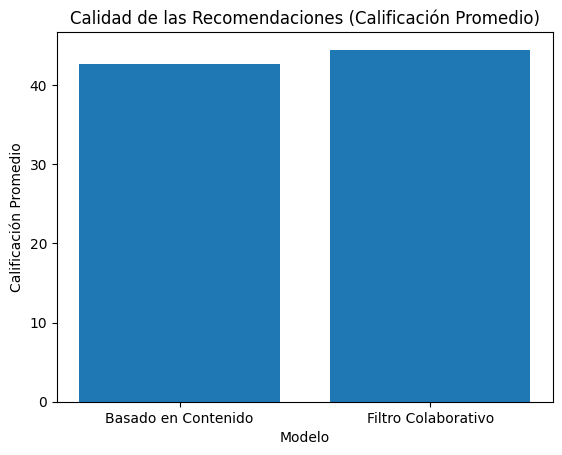

In [61]:
# Obtener las calificaciones promedio de los libros recomendados por cada modelo
calificacion_promedio_content_based = ratings.loc[ratings['Title'].isin(recommended_books_content_based)]['review/score'].mean()
calificacion_promedio_collaborative_filtering = ratings.loc[ratings['Title'].isin(recommended_books_collaborative_filtering)]['review/score'].mean()

# Crear una lista con las calificaciones promedio
calificaciones_promedio = [calificacion_promedio_content_based, calificacion_promedio_collaborative_filtering]

# Crear una lista con los nombres de los modelos
modelos = ['Basado en Contenido', 'Filtro Colaborativo']

# Crear un gráfico de barras
plt.bar(modelos, calificaciones_promedio)

# Agregar título y etiquetas a los ejes
plt.title('Calidad de las Recomendaciones (Calificación Promedio)')
plt.xlabel('Modelo')
plt.ylabel('Calificación Promedio')

# Mostrar el gráfico
plt.show()


# Comparación en Eficiencia del tiempo de ejecución
### tiempo requerido por cada modelo para generar recomendaciones

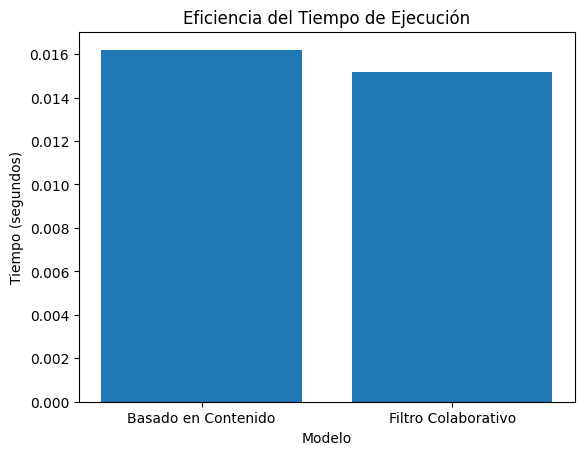

In [65]:
import timeit

# Función lambda para envolver la llamada a recommendations con los argumentos necesarios
recommendations_wrapper = lambda: recommendations(book_title, similarity=similarity)

# Función lambda para envolver la llamada a collaborative_filtering con los argumentos necesarios
collaborative_filtering_wrapper = lambda: collaborative_filtering(User_id, ratings_matrix, User_similarity=User_similarity)

# Medir el tiempo de ejecución del modelo basado en contenido
tiempo_basado_en_contenido = timeit.timeit(recommendations_wrapper, number=1)

# Medir el tiempo de ejecución del modelo de filtro colaborativo
tiempo_filtro_colaborativo = timeit.timeit(collaborative_filtering_wrapper, number=1)

# Crear una lista con los tiempos de ejecución
tiempos_ejecucion = [tiempo_basado_en_contenido, tiempo_filtro_colaborativo]

# Crear una lista con los nombres de los modelos
modelos = ['Basado en Contenido', 'Filtro Colaborativo']

# Crear un gráfico de barras
plt.bar(modelos, tiempos_ejecucion)

# Agregar título y etiquetas a los ejes
plt.title('Eficiencia del Tiempo de Ejecución')
plt.xlabel('Modelo')
plt.ylabel('Tiempo (segundos)')

# Mostrar el gráfico
plt.show()


# Novedad de las recomendaciones
### evalua la novedad de las recomendaciones, es decir, qué tan diferentes son las recomendaciones de cada modelo en comparación con las selecciones populares o comunes. se calcula la cantidad de libros recomendados que no están entre los más populares y representar esta información gráficamente.

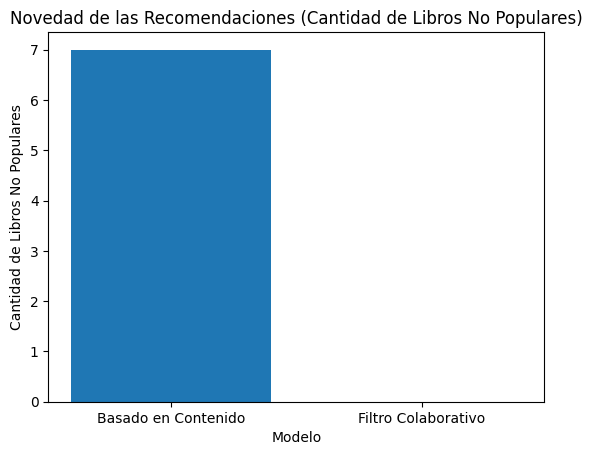

In [66]:
# Obtener la lista de los libros más populares (por ejemplo, los más calificados)
libros_populares = ratings.groupby('Title')['review/score'].count().sort_values(ascending=False).index.tolist()

# Calcular la cantidad de libros recomendados que no están entre los más populares
libros_no_populares_content_based = len(set(recommended_books_content_based) - set(libros_populares))
libros_no_populares_collaborative_filtering = len(set(recommended_books_collaborative_filtering) - set(libros_populares))

# Crear una lista con las cantidades de libros no populares
cantidades_no_populares = [libros_no_populares_content_based, libros_no_populares_collaborative_filtering]

# Crear una lista con los nombres de los modelos
modelos = ['Basado en Contenido', 'Filtro Colaborativo']

# Crear un gráfico de barras
plt.bar(modelos, cantidades_no_populares)

# Agregar título y etiquetas a los ejes
plt.title('Novedad de las Recomendaciones (Cantidad de Libros No Populares)')
plt.xlabel('Modelo')
plt.ylabel('Cantidad de Libros No Populares')

# Mostrar el gráfico
plt.show()
